<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [179]:
# librerias

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

from scipy.stats import bernoulli, beta   
from math import lgamma

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem


In [180]:
# datos
df = pd.read_csv('data/cookie_cats.csv')

df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [181]:
# transformacion
df.info()#No es necesaria transformación de datos.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [182]:
# muestreo
#Colección de datos para crear muestra
control=df[df['version']=='gate_30']
tratamiento=df[df['version']=='gate_40']

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [183]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9998733,gate_40,10,True,False
90185,9999441,gate_40,97,True,False
90186,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [184]:
ab_test.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [185]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44700 entries, 0 to 90186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          44700 non-null  int64 
 1   version         44700 non-null  object
 2   sum_gamerounds  44700 non-null  int64 
 3   retention_1     44700 non-null  bool  
 4   retention_7     44700 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.4+ MB


In [186]:
tratamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45489 entries, 2 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          45489 non-null  int64 
 1   version         45489 non-null  object
 2   sum_gamerounds  45489 non-null  int64 
 3   retention_1     45489 non-null  bool  
 4   retention_7     45489 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.5+ MB


<Axes: xlabel='version'>

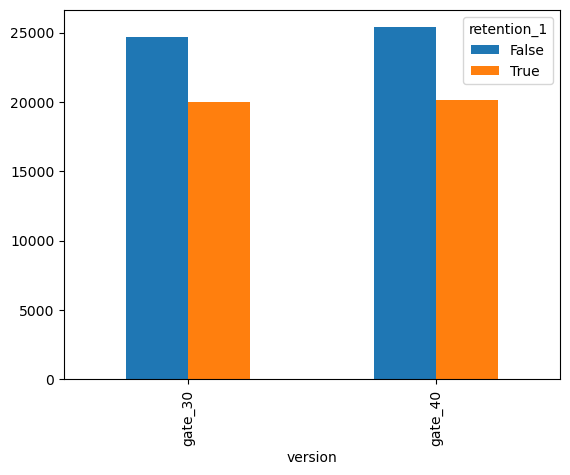

In [187]:
# testeo para retention_1
pd.crosstab(df.version, df.retention_1).plot(kind='bar')


In [188]:
pd.crosstab(df.version, df.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [189]:
imps_ctrl, convs_ctrl = 44700, 20034    #Gate30 impresiones y conversiones retention_1

imps_test, convs_test = 45489, 20119   #Gate40 impresiones y conversiones retention_1


CR_ctrl = convs_ctrl/imps_ctrl

CR_test = convs_test/imps_test

print(f'La tasa de conversión de Gate30 Control es {CR_ctrl}')
print(f'La tasa de conversión de Gate40 Test es {CR_test}')

La tasa de conversión de Gate30 Control es 0.4481879194630872
La tasa de conversión de Gate40 Test es 0.44228274967574577


In [190]:
#Comprobación con Bayes de tasas de conversión.

a_C  = 1+convs_ctrl             # Valor de convertidos version Gate30
b_C = 1+imps_ctrl-convs_ctrl    # Valor de no convertidos version Gate30

a_T = 1+convs_test              # Valor de convertidos en version Gate40
b_T = 1+imps_test-convs_test    # Valor de no convertidos en version Gate40

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

print(f'La tasa de conversión de Gate30 Control es {beta_control.mean()}')
print(f'La tasa de conversión de Gate40 Test es {beta_test.mean()}')

La tasa de conversión de Gate30 Control es 0.44819023757326293
La tasa de conversión de Gate40 Test es 0.44228528719966587


In [191]:

#Funcion para pintar campanas y calcular probabilidad de acierto.
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0, lsup=0.006):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

In [192]:
salto = (beta_test.mean() - beta_control.mean()) / beta_control.mean()
print(f'Con los cambios realizados en la versión de test se han reducido las conversiones un {salto*100}%')

Con los cambios realizados en la versión de test se han reducido las conversiones un -1.3175098158249858%


In [193]:
print(f'Con una probabilidad de {calc_prob(beta_control, beta_test)}')

Con una probabilidad de 0.9627939748515354


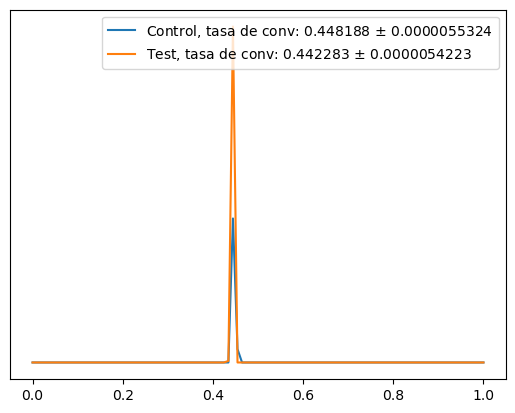

In [194]:
plot([beta_control, beta_test],['Control', 'Test'], linf=0, lsup=1)

<Axes: xlabel='version'>

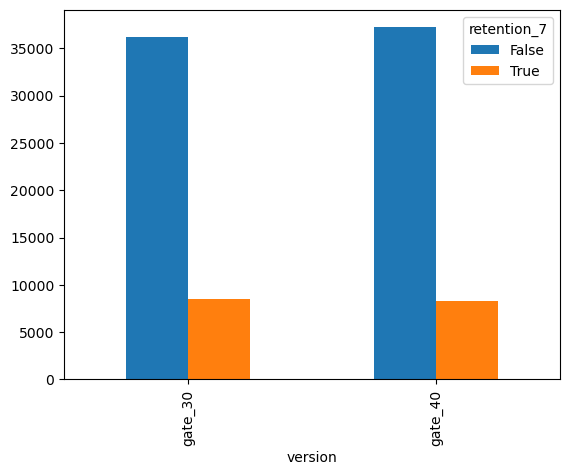

In [195]:
# testeo para retention_7
pd.crosstab(df.version, df.retention_7).plot(kind='bar')


In [196]:
pd.crosstab(df.version, df.retention_7)


retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [197]:
imps_ctrl, convs_ctrl = 44700, 8502    #Gate30 impresiones y conversiones retention_7

imps_test, convs_test = 45489, 8279   #Gate40 impresiones y conversiones retention_7


CR_ctrl = convs_ctrl/imps_ctrl

CR_test = convs_test/imps_test

print(f'La tasa de conversión de Gate30 Control es {CR_ctrl}')
print(f'La tasa de conversión de Gate40 Test es {CR_test}')

La tasa de conversión de Gate30 Control es 0.19020134228187918
La tasa de conversión de Gate40 Test es 0.18200004396667327


In [198]:
#Comprobación con Bayes de tasas de conversión.

a_C  = 1+convs_ctrl             # Valor de convertidos version Gate30
b_C = 1+imps_ctrl-convs_ctrl    # Valor de no convertidos version Gate30

a_T = 1+convs_test              # Valor de convertidos en version Gate40
b_T = 1+imps_test-convs_test    # Valor de no convertidos en version Gate40

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

print(f'La tasa de conversión de Gate30 Control es {beta_control.mean()}')
print(f'La tasa de conversión de Gate40 Test es {beta_test.mean()}')

La tasa de conversión de Gate30 Control es 0.19021520289919913
La tasa de conversión de Gate40 Test es 0.18201402475214878


In [199]:
salto = (beta_test.mean() - beta_control.mean()) / beta_control.mean()
print(f'Con los cambios realizados en la versión de test se han reducido las conversiones un {salto*100}%')

Con los cambios realizados en la versión de test se han reducido las conversiones un -4.311526114658881%


In [200]:
print(f'Con una probabilidad de {calc_prob(beta_control, beta_test)}')

Con una probabilidad de 0.9992226613235504


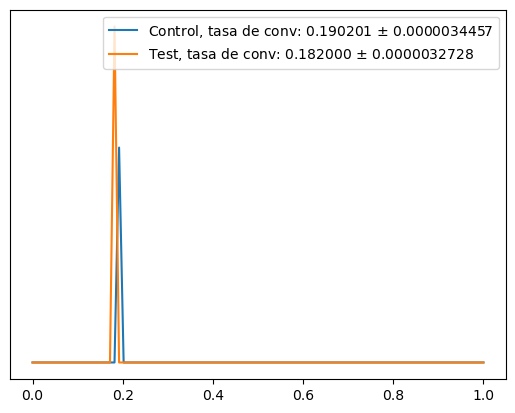

In [210]:
plot([beta_control, beta_test],['Control', 'Test'], linf=0, lsup=1)

# La versión de 1 dia tiene un ratio de conversión mayor que la de 7 días, siendo el ratio un 1,31% mayor si la puerta se encuentra en el nivel 30. La conclusión sería que lo mas productivo en terminos de conversión sería mantener la versión de 1 dia en la puerta 30.

